Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50

# Set Path

In [2]:
train_dataset_path = 'dataset/training_set/'
test_dataset_path = 'dataset/test_set/'

# Image Resizing 

In [3]:
BATCH_SIZE = 32
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

Batch Size: 32
Image Shape: (256, 256, 3)


# Data Augumentation

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  vertical_flip = True,
                                  fill_mode = 'nearest',
                                  validation_split = 0.1)

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'binary',
                                                   shuffle = True,
                                                   subset = 'training',
                                                   seed = 2)

Found 7200 images belonging to 2 classes.


In [5]:
validation_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                        target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'binary',
                                                        subset = 'validation',
                                                        shuffle = True,
                                                        seed = 2)

Found 800 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1.0/ 255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary',
                                                 shuffle = False)

Found 2000 images belonging to 2 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

0 : cats
1 : dogs


# View Sample Images

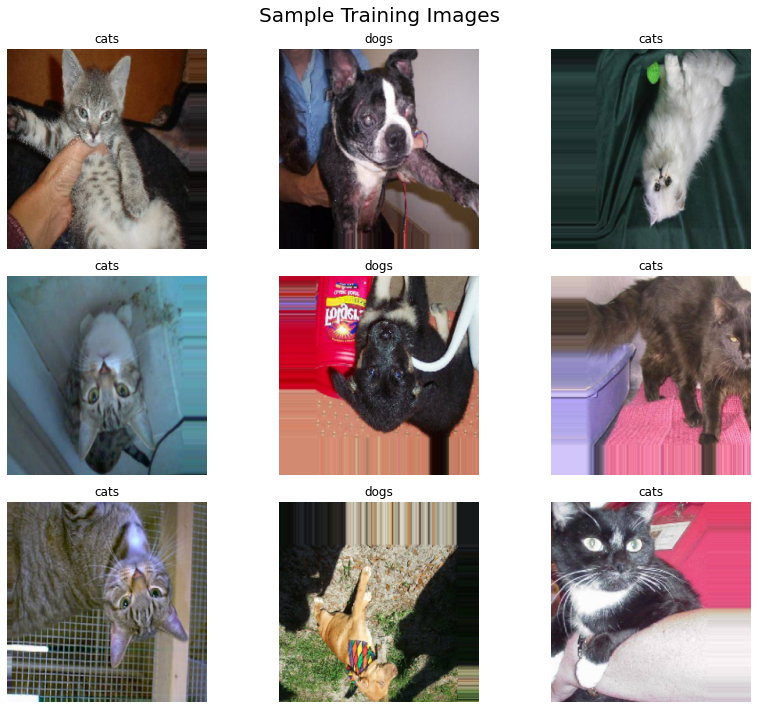

In [8]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images", fontsize = 20)
for i in range(3):
    for j in range(3):
        label = labels[train_generator[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# VGG16 model

In [9]:
base_model = VGG16(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = False

In [11]:
inputs = Input(shape = IMG_SHAPE)

x = base_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)

In [14]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate=base_learning_rate)

In [15]:
model.compile(
    optimizer = optimizer,
    loss = BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [17]:
initial_epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=5,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)

Epoch 1/10
5/5 [==============================] - 23s 5s/step - loss: 0.9400 - accuracy: 0.5000 - val_loss: 0.7891 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 17s 4s/step - loss: 0.8936 - accuracy: 0.4875 - val_loss: 0.7331 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 17s 4s/step - loss: 0.7849 - accuracy: 0.5188 - val_loss: 0.6998 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 16s 4s/step - loss: 0.7284 - accuracy: 0.5562 - val_loss: 0.6854 - val_accuracy: 0.5587
Epoch 5/10
5/5 [==============================] - 17s 4s/step - loss: 0.8224 - accuracy: 0.4625 - val_loss: 0.6853 - val_accuracy: 0.5288
Epoch 6/10
5/5 [==============================] - 17s 4s/step - loss: 0.7495 - accuracy: 0.5063 - val_loss: 0.6913 - val_accuracy: 0.5013
Epoch 7/10
5/5 [==============================] - 17s 4s/step - loss: 0.7823 - accuracy: 0.5125 - val_loss: 0.6957 - val_accuracy: 0.4988
Epoch 8/10
5/5 [==================

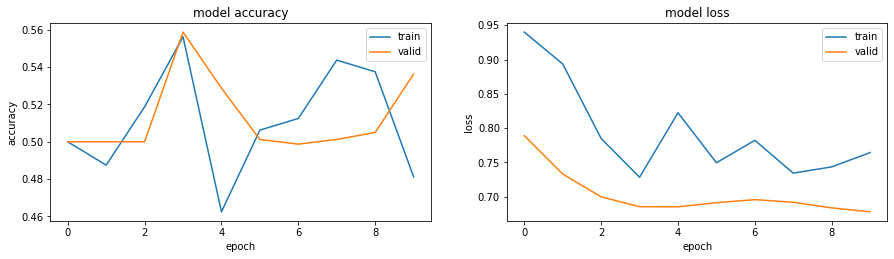

In [18]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# CNN Architecture

In [20]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[256,256,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [21]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [26]:
model = cnn.fit_generator(train_generator, steps_per_epoch=10, epochs=10,
                              validation_data= validation_generator, 
                              verbose=1) 

Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 0.6658 - accuracy: 0.5813 - val_loss: 0.6608 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 0.6736 - accuracy: 0.6125 - val_loss: 0.6585 - val_accuracy: 0.5938
Epoch 3/10
10/10 [==============================] - 19s 2s/step - loss: 0.6577 - accuracy: 0.5719 - val_loss: 0.6563 - val_accuracy: 0.5938
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.6479 - accuracy: 0.5844 - val_loss: 0.6461 - val_accuracy: 0.6338
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 0.6672 - accuracy: 0.5531 - val_loss: 0.6590 - val_accuracy: 0.6025
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.6513 - accuracy: 0.6469 - val_loss: 0.6600 - val_accuracy: 0.6037
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.6361 - accuracy: 0.6406 - val_loss: 0.6560 - val_accuracy: 0.6000
Epoch 8/10
10/10 [==

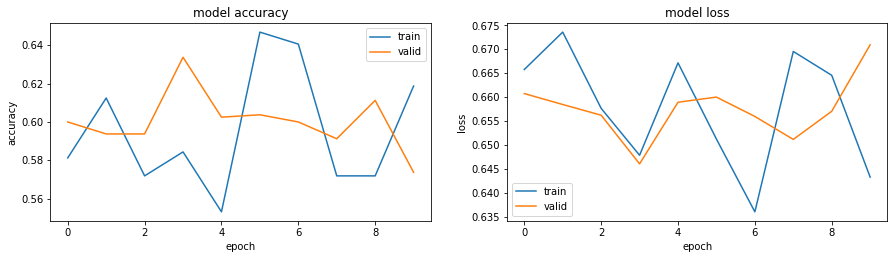

In [27]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(model.history['accuracy'])  
plt.plot(model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(model.history['loss'])  
plt.plot(model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()